## Feature Attributions

In [7]:
import requests
import zipfile
import io
import pandas as pd
# URL for the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases\
/00275/Bike-Sharing-Dataset.zip"
# Send a HTTP request to the URL of the webpage you want to access
response = requests.get(url)

In [8]:
# Create a ZipFile object from the response content
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
# Extract the 'day.csv' or 'hour.csv' file from the ZipFile object
csv_file = zip_file.open('day.csv')
# Read the CSV data
data = pd.read_csv(csv_file)

In [9]:
from sklearn.model_selection import train_test_split
# Drop the 'dteday' column
data = data.drop('dteday', axis=1)
# Split the data into predictors and target
X = data.drop(['cnt', 'casual', 'registered'], axis=1)
y = data['cnt']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, \
test_size=0.2, random_state=0)


In [10]:
from sklearn.ensemble import RandomForestRegressor

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

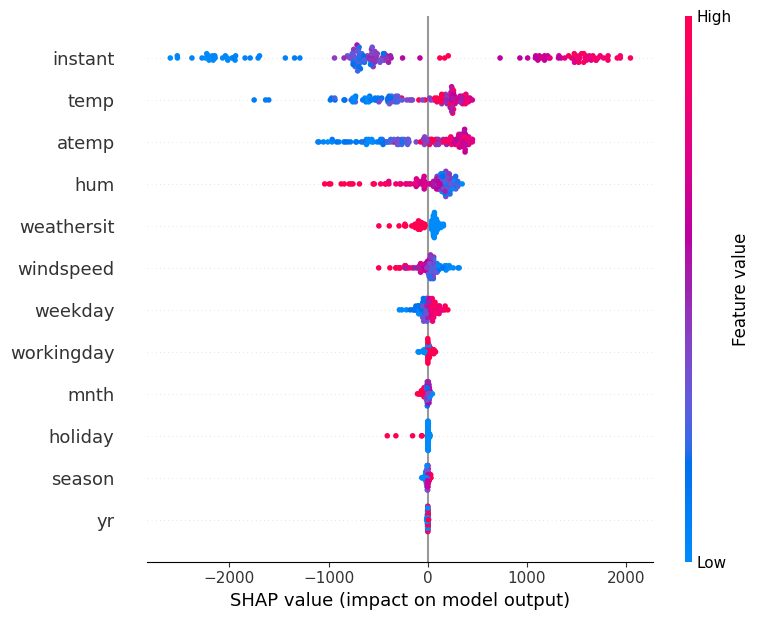

In [16]:
import shap
import matplotlib.pyplot as plt


# Initialize the SHAP explainer
explainer = shap.Explainer(model)

# Compute SHAP values
shap_values = explainer(X_test)

# Plot summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns,show=False, 
                #   plot_type='violin'
)
plt.savefig('pictures/shap_summary_plot.pdf', bbox_inches='tight')



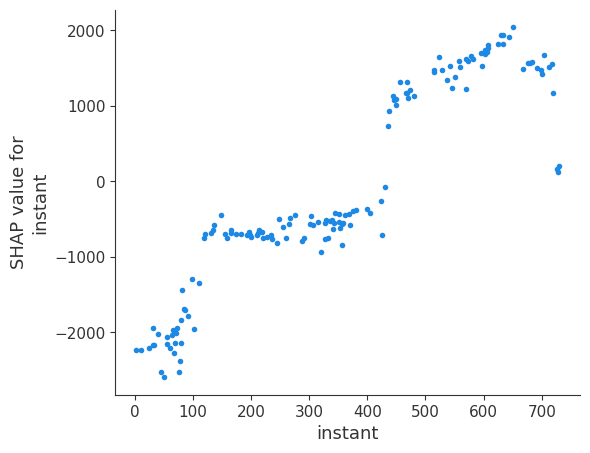

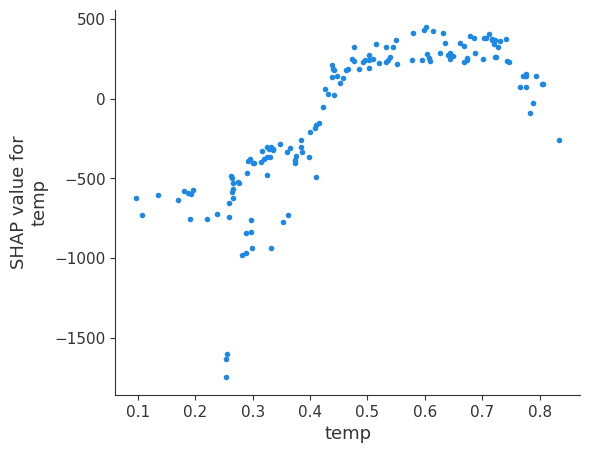

In [12]:
# Create a SHAP dependence plot to show interactions between features
for name in ['instant', 'temp']:
    shap.dependence_plot(name, shap_values.values, X_test, interaction_index=None)

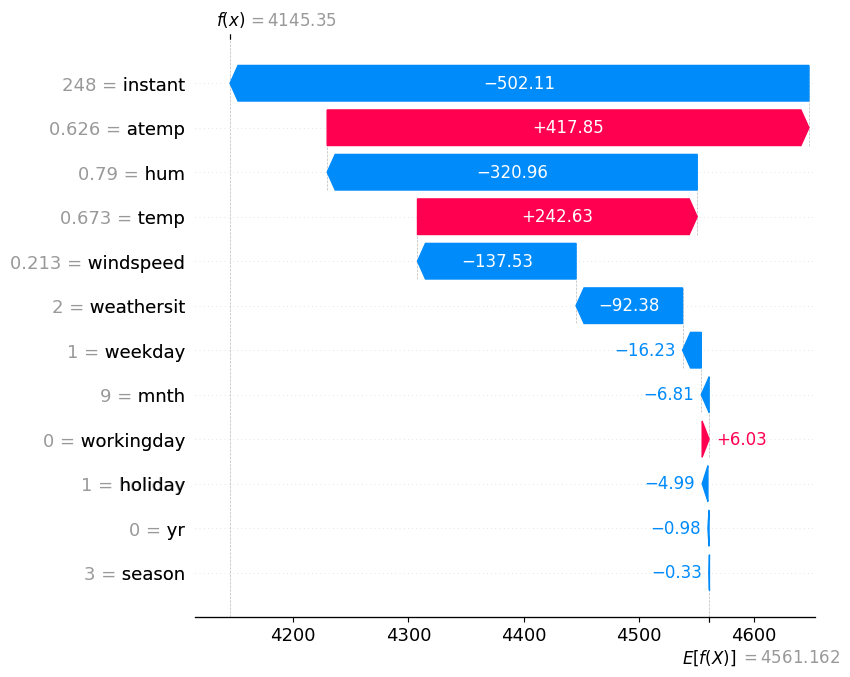

In [13]:
sample_ind = 50
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

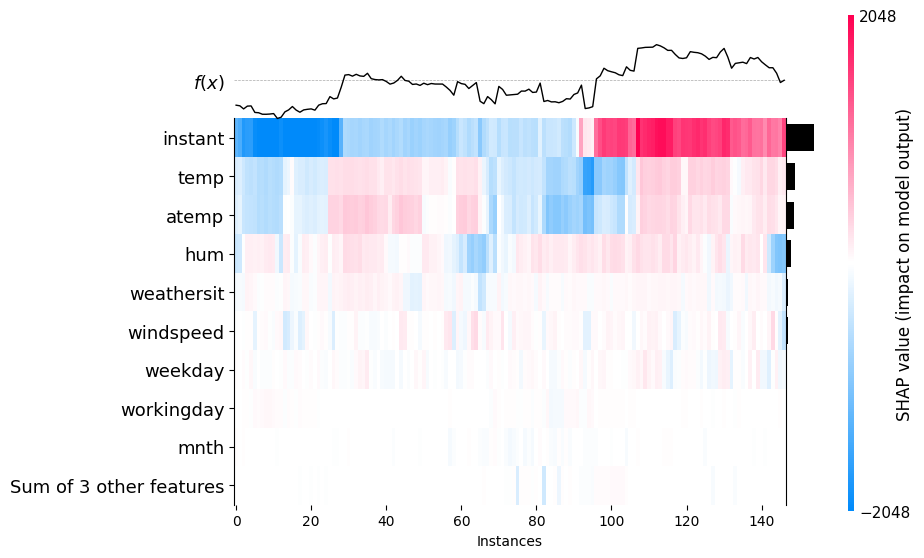

In [14]:
shap.plots.heatmap(shap_values)

## Counterfactual Explanations

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
import dice_ml
from dice_ml.utils import helpers  # helper functions for DiCE

# Load the dataset
url = "https://github.com/ziadasal/Credit-Risk-Assessment/raw/main/german_credit_data.csv"
data = pd.read_csv(url).drop('Unnamed: 0', axis=1)



In [2]:
# Preprocess the dataset
# Encode categorical variables using LabelEncoder
for column in data.columns:
    if data[column].dtype == type(object):
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])

# Define features and target variable
X = data.drop(columns=['Risk'])
y = data['Risk']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

X_train_ext = X_train.copy()
X_train_ext['Risk'] = y_train

# # Scale features using StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [3]:
# Train an MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, 5), max_iter=1000, alpha=0.01, random_state=1)
mlp.fit(X_train, y_train)

MLPClassifier(alpha=0.01, hidden_layer_sizes=(10, 5), max_iter=1000,
              random_state=1)

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predictions on the test set
y_pred = mlp.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')

# Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.2f}')

# F1-score
f1 = f1_score(y_test, y_pred)
print(f'F1-score: {f1:.2f}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)


Accuracy: 0.76
Precision: 0.83
Recall: 0.83
F1-score: 0.83
Confusion Matrix:
[[ 33  25]
 [ 24 118]]


In [5]:
query_instance_df = X_test.sample(1)

In [6]:
# Setup DiCE
d = dice_ml.Data(dataframe=X_train_ext, continuous_features=list(X.columns), outcome_name='Risk')
m = dice_ml.Model(model=mlp, backend="sklearn")

# Create a DiCE explanation instance
exp = dice_ml.Dice(d, m)

# Generate counterfactual explanations for a sample query instance from the test set

dice_exp = exp.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class='opposite')
dice_exp.visualize_as_dataframe(show_only_changes=True)


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

Query instance (original outcome : 0)


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,23,0,3,2,0,1,11560,24,1,0



Diverse Counterfactual set (new outcome: 1)


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,46,-,-,-,4,-,-,-,-,1
1,-,-,-,-,4,-,-,-,-,1
2,66,-,-,-,-,-,-,-,-,1
3,73,-,-,-,-,-,-,-,-,1
4,74,-,-,-,-,-,-,18,-,1
